In [43]:
import os
import torch
import librosa
import numpy as np
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from scipy.signal import butter, lfilter
import scipy.io
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import sklearn.metrics as metrics
from torchsummary import summary

seed = 1
np.random.seed(seed)
rng = np.random.default_rng(seed) # seeded random number generator

### Preprocessing functions

In [44]:
# Preprocessing functions
def load_audio_file(file_path, target_sample_rate = 2000):
    audio_data, sample_rate = librosa.load(file_path, sr=target_sample_rate)
    # if (sample_rate - target_sample_rate)**2 > 100:
    #   audio_data, sample_rate = librosa.load(file_path, sr=2000)
    return audio_data, sample_rate

def butter_lowpass(cutoff, fs, order=5):
  nyq = 0.5 * fs
  normal_cutoff = cutoff / nyq
  b, a = butter(order, normal_cutoff, btype='low', analog=False)
  return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
  b, a = butter_lowpass(cutoff, fs, order=order)
  y = lfilter(b, a, data)
  return y

def apply_lowpass_filter(audio_data, sample_rate, cutoff=195):
  filtered_data = butter_lowpass_filter(audio_data, cutoff, sample_rate)
  return filtered_data

def perform_fft(filtered_data):
  fft_data = np.fft.fft(filtered_data)
  return fft_data

### Data Augmentation functions


##### Time Shifting - shift the audio signal by a random amount

In [45]:
def time_shift(audio_data, sample_rate):
    shift_amount = int(sample_rate * np.random.uniform(-0.1, 0.1))
    shifted_data = np.roll(audio_data, shift_amount)
    return shifted_data

##### Pitch Shifting - Change the pitch of the audio signal by a random factor

In [46]:
def pitch_shift(audio_data, sample_rate):
    pitch_shift_amount = np.random.uniform(-1.0, 1.0)
    shifted_data = librosa.effects.pitch_shift(audio_data, sr=sample_rate, n_steps=pitch_shift_amount)
    return shifted_data

##### Add Random Noise

In [47]:
def add_noise(audio_data):
    noise_level = np.random.uniform(0.005, 0.05)
    noise = np.random.randn(len(audio_data)) * noise_level
    noisy_data = audio_data + noise # add noise ~ normal(mean=0, std=noise_level)
    return noisy_data

In [ ]:
audio_data,_ = 

### Building Dataset

In [48]:
class HeartSoundDataset(Dataset):
    def __init__(self, file_paths, labels, num_output_samples, transform=None, weights=None, augmentation=False):
        self.file_paths = file_paths
        if torch.is_tensor(labels):
          self.labels = labels
        else:
          self.labels = torch.from_numpy(labels).float()
        self.transform = transform
        self.num_output_samples = num_output_samples
        self.weights = weights
        self.augmentation = augmentation

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        # file_path = self.file_paths[idx]
        # audio_data, sample_rate = load_audio_file(file_path)
        # file_paths is an array of all recordings
        audio_data = self.file_paths[idx]
        sample_rate = 2000
        # Apply data augmentation techniques if the augmentation parameter is set to True
        if self.augmentation:
            audio_data = time_shift(audio_data, sample_rate)
            audio_data = pitch_shift(audio_data, sample_rate)
            audio_data = add_noise(audio_data)

        filtered_data = apply_lowpass_filter(audio_data, sample_rate)
        fft_data = perform_fft(filtered_data)

        # Use only the real part of the FFT data
        real_fft_data = np.real(fft_data)

        # Normalize data
        normalized_data = (real_fft_data - np.min(real_fft_data)) / (np.max(real_fft_data) - np.min(real_fft_data))

        if self.transform:
            normalized_data = self.transform(normalized_data)

        label = self.labels[idx]

        if self.weights:
          weight = self.weights[idx]
          return torch.tensor(normalized_data[:self.num_output_samples]).float(), label, weight

        return torch.tensor(normalized_data[:self.num_output_samples]).float(), label



In [49]:
def create_dataloaders(file_paths, labels, max_num_samples, rng, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, batch_size=100, weights=None, augmentation=True):
    dataset_size = len(file_paths)
    train_size = int(train_ratio * dataset_size)
    val_size = int(val_ratio * dataset_size)
    test_size = dataset_size - train_size - val_size

    dataset = HeartSoundDataset(file_paths, labels, max_num_samples)
    train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size]) #, generator=rng)

    if weights:
      # Apply data augmentation only to the training dataset
      train_set.dataset = HeartSoundDataset(train_set.dataset.file_paths, train_set.dataset.labels, 
                                            train_set.dataset.num_output_samples, weights=weights, augmentation=augmentation)

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


### Classifier with Dropout and Regularization (REVIEW)

In [50]:
class HeartSoundClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(HeartSoundClassifier, self).__init__()
        self.cnn_layers = nn.Sequential(
            # 1st Conv
            nn.Conv1d(1, 8, kernel_size=19, stride=1),
            nn.BatchNorm1d(8), # BATCH 
            nn.ReLU(),
            nn.MaxPool1d(16),
            nn.Dropout(0.5), # DROPOUT
        
            # 2nd Conv
            nn.Conv1d(8, 16, kernel_size=19, stride=1),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.MaxPool1d(16),
            nn.Dropout(0.5),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(528, 32),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(32, 1) # Single logit to feed into Sigmoid
            # self.softmax = nn.Softmax(0)
        )

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.cnn_layers(x)
        x = self.classifier(x)
        return x

In [51]:
class HeartSoundClassifier2(nn.Module):
    def __init__(self):
        super(HeartSoundClassifier2, self).__init__()
        self.cnn_layers = nn.Sequential(
            # 1st Conv Layer
            nn.Conv1d(1, 8, kernel_size=5, stride=1),
            nn.BatchNorm1d(8),
            nn.ReLU(),
            nn.MaxPool1d(2),
            # 2nd Conv Layer
            nn.Conv1d(8, 4, kernel_size=5, stride=1),
            nn.BatchNorm1d(4),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(0.25)
        )
        self.classifier = nn.Sequential(
          nn.Flatten(),
          nn.Linear(4*2247, 32),
          nn.Dropout(0.5),
          nn.ReLU(),
          nn.Linear(32, 1)
        )

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.cnn_layers(x)
        x = self.classifier(x)
        return x

In [52]:
def write_prepped_audio(label_dir, file_name, audio_sample_len, target_sample_rate = 2000):
  if file_name[-4:] != ".wav": return None, None

  if not os.path.exists(os.path.join(label_dir, "prepped_audio")):
    os.makedirs(os.path.join(label_dir, "prepped_audio"))
  new_file_path = os.path.join(label_dir, "prepped_audio", file_name)
  if os.path.exists(new_file_path): return new_file_path, None

  audio_data, sample_rate = load_audio_file(os.path.join(label_dir, file_name), target_sample_rate)

  # if audio_data is shorter than 1/3 the target audio sample length, return None
  # else, pad with zeros
  if len(audio_data) < audio_sample_len/3:
    return None, None
  elif len(audio_data) < audio_sample_len:
    audio_data = np.concatenate((audio_data, np.zeros(audio_sample_len)), dtype=np.float32)
  scipy.io.wavfile.write(new_file_path, sample_rate, audio_data[:audio_sample_len])
  return new_file_path, audio_data[:audio_sample_len]

# Training, Validation, Testing

In [53]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
# Load data and create data loaders
# data_dir = '/content/drive/MyDrive/MLMA Group/CardiacData/DatasetB'
data_dir = '/content/drive/MyDrive/MLMA Group/CardiacData/physionet cardiac sounds/heart_sound/train'
label_encoder = LabelEncoder()

file_paths = []
labels = []
audio_sample_len = 9000
target_sample_rate = 2000
data = []

for label in os.listdir(data_dir):
  label_dir = os.path.join(data_dir, label)
  for file_name in os.listdir(label_dir):
    new_file_path, _ = write_prepped_audio(label_dir, file_name, audio_sample_len, target_sample_rate)
    if new_file_path is not None:
      file_paths.append(new_file_path)
      labels.append(label)
      audio_data, _ = load_audio_file(os.path.join(label_dir, file_name))
      # Store all recordings into a list
      data.append(audio_data[:audio_sample_len])
data_array = np.vstack(data)
encoded_labels = label_encoder.fit_transform(labels)



In [55]:
# Create weights for unbalanced dataset
class_counts = dict(Counter(labels))
class_weights = [class_counts['healthy']/len(labels), class_counts['unhealthy']/len(labels)]
weights = list()
for label in encoded_labels:
  weights.append(class_weights[label])

train_loader, val_loader, test_loader = create_dataloaders(data_array, encoded_labels, audio_sample_len, rng, weights=weights, augmentation=False)


In [56]:
# Initialize the model, loss function, and optimizer
model = HeartSoundClassifier2()
criterion = nn.BCEWithLogitsLoss(reduction='none')
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=0.0007, weight_decay=1e-5)

summary(model.cuda(), input_size=(9000,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 8, 8996]              48
       BatchNorm1d-2              [-1, 8, 8996]              16
              ReLU-3              [-1, 8, 8996]               0
         MaxPool1d-4              [-1, 8, 4498]               0
            Conv1d-5              [-1, 4, 4494]             164
       BatchNorm1d-6              [-1, 4, 4494]               8
              ReLU-7              [-1, 4, 4494]               0
         MaxPool1d-8              [-1, 4, 2247]               0
           Dropout-9              [-1, 4, 2247]               0
          Flatten-10                 [-1, 8988]               0
           Linear-11                   [-1, 32]         287,648
          Dropout-12                   [-1, 32]               0
             ReLU-13                   [-1, 32]               0
           Linear-14                   

### Early Stopping (REVIEW) 

In [57]:
# Set early stopping parameters
patience = 5
min_delta = 0.001
num_epochs = 100

def train_model(model, train_loader, val_loader, optimizer, num_epochs=10, classifier_threshold=0.5, patience=5, min_delta=0.001):
  train_losses = []
  val_losses = []
  train_accs = []
  val_accs = []

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)

  # Initialize variables to track best validation loss and epochs without improvement
  best_val_loss = 0
  epochs_without_improvement = 0

  for epoch in range(num_epochs):
    # Train the model
    model.train()
    train_loss = 0.0
    train_correct = 0
    for batch_num, (data, labels, weights) in enumerate(train_loader):
      data, labels, weights = data.to(device), labels.to(device), weights.to(device)
      optimizer.zero_grad()
      output_logits = model(data)[:,0]
      intermediate_loss = criterion(output_logits, labels)
      loss = torch.mean(weights*intermediate_loss)
      loss.backward()
      optimizer.step()
      train_loss += loss.item() * data.shape[0]
      pred = nn.Sigmoid()(output_logits)
      pred = torch.where(pred > classifier_threshold, 1, 0)
      train_correct += (pred == labels).long().sum().item()

    # Compute training accuracy and loss
    train_acc = 100 * train_correct / len(train_loader.dataset)
    train_loss /= len(train_loader.dataset)
    train_accs.append(train_acc)
    train_losses.append(train_loss)

    # Validate the model
    model.eval()
    val_loss = 0.0
    val_correct = 0
    with torch.no_grad():
      for data, labels in val_loader:
        data, labels = data.to(device), labels.to(device)
        output_logits = model(data)[:,0]
        intermediate_loss = criterion(output_logits, labels)
        loss = torch.mean(intermediate_loss)
        val_loss += loss.item() * data.shape[0]
        pred = nn.Sigmoid()(output_logits)
        pred = torch.where(pred > classifier_threshold, 1, 0)
        val_correct += (pred==labels).long().sum().item()

    # Compute validation accuracy and loss
    val_acc = 100 * val_correct / len(val_loader.dataset)
    val_loss /= len(val_loader.dataset)
    val_accs.append(val_acc)
    val_losses.append(val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%')

    # Early stopping logic
    if abs(val_loss - best_val_loss) > min_delta:
      best_val_loss = val_loss
      epochs_without_improvement = 0
    else:
      epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
      print(f'Early stopping triggered after {epoch+1} epochs')
      torch.save(model.state_dict(),'/content/drive/MyDrive/Colab Notebooks/ML for Medication Apps/Project/physionet_model.pt')
      return train_losses, train_accs, val_losses, val_accs
    torch.save(model.state_dict(),'/content/drive/MyDrive/Colab Notebooks/ML for Medication Apps/Project/physionet_model.pt')
  return train_losses, train_accs, val_losses, val_accs

train_losses, train_accs, val_losses, val_accs = train_model(model, train_loader, val_loader, optimizer, num_epochs, patience=patience, min_delta=min_delta)

Epoch [1/100], Training Loss: 0.1984, Training Accuracy: 78.79%, Validation Loss: 0.5714, Validation Accuracy: 79.42%
Epoch [2/100], Training Loss: 0.1398, Training Accuracy: 79.72%, Validation Loss: 0.4719, Validation Accuracy: 79.42%
Epoch [3/100], Training Loss: 0.1302, Training Accuracy: 79.59%, Validation Loss: 0.4100, Validation Accuracy: 79.42%
Epoch [4/100], Training Loss: 0.1281, Training Accuracy: 79.67%, Validation Loss: 0.3943, Validation Accuracy: 79.42%
Epoch [5/100], Training Loss: 0.1191, Training Accuracy: 79.67%, Validation Loss: 0.4343, Validation Accuracy: 79.42%
Epoch [6/100], Training Loss: 0.1187, Training Accuracy: 79.67%, Validation Loss: 0.4153, Validation Accuracy: 79.42%
Epoch [7/100], Training Loss: 0.1165, Training Accuracy: 79.67%, Validation Loss: 0.3674, Validation Accuracy: 79.42%
Epoch [8/100], Training Loss: 0.1163, Training Accuracy: 79.67%, Validation Loss: 0.3931, Validation Accuracy: 79.42%
Epoch [9/100], Training Loss: 0.1107, Training Accuracy:

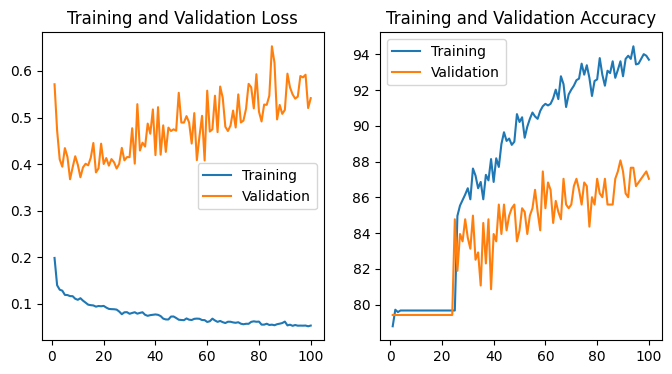

In [60]:
fig, ax = plt.subplots(1,2, figsize=(8,4))
x = range(1,len(train_losses)+1)
ax[0].set_title('Training and Validation Loss')
ax[0].plot(x, train_losses, label='Training')
ax[0].plot(x, val_losses, label='Validation')
ax[0].legend()
ax[1].set_title('Training and Validation Accuracy')
ax[1].plot(x, train_accs, label='Training')
ax[1].plot(x, val_accs, label='Validation')
ax[1].legend()

### Train and Validate

In [61]:
def Test_model(model, test_dataloader, classifier_threshold=0.5):
  """Test model on test dataset and returns predictions and targets"""
  model.eval()
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)
  test_loss = 0.0
  test_correct = 0
  target = []
  prediction = []
  with torch.no_grad():
    for data, labels in test_dataloader:
      data, labels = data.to(device), labels.to(device)
      output_logits = model(data)[:,0]

      pred = nn.Sigmoid()(output_logits)
      pred = torch.where(pred > classifier_threshold, 1, 0)
      prediction.append(pred.cpu().tolist())
      target.append(labels.cpu().tolist())
  target = np.hstack(target)
  prediction = np.hstack(prediction)

  return target, prediction

In [62]:
# Test the model
model = HeartSoundClassifier2()
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/ML for Medication Apps/Project/physionet_model.pt'))
y_true, y_pred = Test_model(model, test_loader)
# model.eval()
# with torch.no_grad():
#     y_true = []
#     y_pred = []
#     for data, labels in test_loader:
#         outputs = model(data)
#         _, predicted = torch.max(outputs.data, 1)
#         y_true.extend(labels.numpy())
#         y_pred.extend(predicted.numpy())



### F1, Precision, Recall, Sensitivity, Specificity, TP, FP, TN, FN, plot and ROC curve and calculate AUC


Classification Report:
              precision    recall  f1-score   support

     healthy       0.85      0.97      0.91       382
   unhealthy       0.80      0.38      0.52       104

    accuracy                           0.85       486
   macro avg       0.83      0.68      0.71       486
weighted avg       0.84      0.85      0.83       486



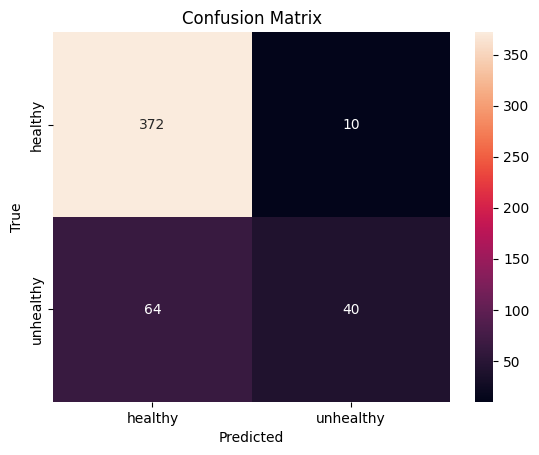

In [63]:
# Evaluation metrics
print('\nClassification Report:')
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

confusion_mtx = confusion_matrix(y_true, y_pred)
sns.heatmap(confusion_mtx, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [64]:
recall = metrics.recall_score(y_true,y_pred)
precision = metrics.precision_score(y_true,y_pred)
accuracy = metrics.accuracy_score(y_true,y_pred)
f1_score = metrics.f1_score(y_true,y_pred)
print(f"Test metrics:\n\tRecall-rate: {recall:.4f}\n\tPrecision: {precision:.4f}"
      +f"\n\tAccuracy: {accuracy:.4f}\n\tF1-Score: {f1_score:.4f}")

Test metrics:
	Recall-rate: 0.3846
	Precision: 0.8000
	Accuracy: 0.8477
	F1-Score: 0.5195


# Transfer Learning

In [65]:
# Load DatasetB

data_dir = '/content/drive/MyDrive/MLMA Group/CardiacData/DatasetB'
label_encoder = LabelEncoder()

file_paths = []
labels = []
audio_sample_len = 9000
target_sample_rate = 2000
data = []

for label in os.listdir(data_dir):
  label_dir = os.path.join(data_dir, label)
  for file_name in os.listdir(label_dir):
    new_file_path, _ = write_prepped_audio(label_dir, file_name, audio_sample_len, target_sample_rate)
    if new_file_path is not None:
      file_paths.append(new_file_path)
      labels.append(label)
      audio_data, _ = load_audio_file(new_file_path)
      # Store all recordings into a list
      data.append(audio_data[:audio_sample_len])

data_array = np.vstack(data)
encoded_labels = label_encoder.fit_transform(labels)



In [66]:
# Create weights for unbalanced dataset
class_counts = dict(Counter(labels))
classes = label_encoder.classes_
class_weights = [class_counts[classes[0]]/len(labels), class_counts[classes[1]]/len(labels), class_counts[classes[2]]/len(labels)]

train_loader, val_loader, test_loader = create_dataloaders(data_array, encoded_labels, audio_sample_len, rng, augmentation=False)

In [67]:
class PASCALClassifier(nn.Module):
    def __init__(self, pretrained_cnn):
        super(PASCALClassifier, self).__init__()
        self.cnn = pretrained_cnn
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(4*2247, 32),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(32, 3)
        )

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.cnn(x)
        x = self.classifier(x)
        return x


In [68]:
# Load pretrained model
pretrained_model = HeartSoundClassifier2()
pretrained_model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/ML for Medication Apps/Project/physionet_model.pt'))
cnn = pretrained_model.cnn_layers

# Freeze CNN layers
for param in cnn.parameters():
  param.requires_grad = False

# Add new classification layers to tune
PASCAL_model = PASCALClassifier(cnn)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = torch.FloatTensor(class_weights).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(PASCAL_model.classifier.parameters(), lr=0.0007, weight_decay=1e-5)
summary(PASCAL_model.cuda(), input_size=(9000,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 8, 8996]              48
       BatchNorm1d-2              [-1, 8, 8996]              16
              ReLU-3              [-1, 8, 8996]               0
         MaxPool1d-4              [-1, 8, 4498]               0
            Conv1d-5              [-1, 4, 4494]             164
       BatchNorm1d-6              [-1, 4, 4494]               8
              ReLU-7              [-1, 4, 4494]               0
         MaxPool1d-8              [-1, 4, 2247]               0
           Dropout-9              [-1, 4, 2247]               0
          Flatten-10                 [-1, 8988]               0
           Linear-11                   [-1, 32]         287,648
          Dropout-12                   [-1, 32]               0
             ReLU-13                   [-1, 32]               0
           Linear-14                   

In [69]:
# Finetune classifier
# Set early stopping parameters
patience = 5
min_delta = 0.001
num_epochs = 100

def tune_model(model, criterion, train_loader, val_loader, optimizer, num_epochs=10, patience=5, min_delta=0.001):
  train_losses = []
  val_losses = []
  train_accs = []
  val_accs = []

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)

  # Initialize variables to track best validation loss and epochs without improvement
  best_val_loss = 0
  epochs_without_improvement = 0

  for epoch in range(num_epochs):
    # Train the model
    model.train()
    train_loss = 0.0
    train_correct = 0
    for batch_num, (data, labels) in enumerate(train_loader):
      labels = labels.type(torch.LongTensor)
      data, labels = data.to(device), labels.to(device)
      optimizer.zero_grad()
      output_logits = model(data)
      loss = criterion(output_logits, labels)
      loss.backward()
      optimizer.step()
      train_loss += loss.item() * data.shape[0]
      pred = torch.softmax(output_logits, dim=1)
      pred = pred.argmax(dim=1)
      train_correct += (pred == labels).long().sum().item()

    # Compute training accuracy and loss
    train_acc = 100 * train_correct / len(train_loader.dataset)
    train_loss /= len(train_loader.dataset)
    train_accs.append(train_acc)
    train_losses.append(train_loss)

    # Validate the model
    model.eval()
    val_loss = 0.0
    val_correct = 0
    with torch.no_grad():
      for data, labels in val_loader:
        labels = labels.type(torch.LongTensor)
        data, labels = data.to(device), labels.to(device)
        output_logits = model(data)
        loss = criterion(output_logits, labels)
        val_loss += loss.item() * data.shape[0]
        pred = torch.softmax(output_logits, dim=1)
        pred = pred.argmax(dim=1)
        val_correct += (pred==labels).long().sum().item()

    # Compute validation accuracy and loss
    val_acc = 100 * val_correct / len(val_loader.dataset)
    val_loss /= len(val_loader.dataset)
    val_accs.append(val_acc)
    val_losses.append(val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%')

    # Early stopping logic
    if abs(val_loss - best_val_loss) > min_delta:
      best_val_loss = val_loss
      epochs_without_improvement = 0
    else:
      epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
      print(f'Early stopping triggered after {epoch+1} epochs')
      torch.save(model.state_dict(),'/content/drive/MyDrive/Colab Notebooks/ML for Medication Apps/Project/pascal_model.pt')
      return train_losses, train_accs, val_losses, val_accs
    torch.save(model.state_dict(),'/content/drive/MyDrive/Colab Notebooks/ML for Medication Apps/Project/pascal_model.pt')
  
  return train_losses, train_accs, val_losses, val_accs

train_losses, train_accs, val_losses, val_accs = tune_model(PASCAL_model, criterion, train_loader, val_loader, optimizer, num_epochs, patience=patience, min_delta=min_delta)

Epoch [1/100], Training Loss: 0.9199, Training Accuracy: 45.81%, Validation Loss: 0.5709, Validation Accuracy: 62.79%
Epoch [2/100], Training Loss: 0.6741, Training Accuracy: 62.07%, Validation Loss: 0.5656, Validation Accuracy: 62.79%
Epoch [3/100], Training Loss: 0.6931, Training Accuracy: 62.07%, Validation Loss: 0.5426, Validation Accuracy: 62.79%
Epoch [4/100], Training Loss: 0.5858, Training Accuracy: 63.55%, Validation Loss: 0.5912, Validation Accuracy: 65.12%
Epoch [5/100], Training Loss: 0.5391, Training Accuracy: 64.04%, Validation Loss: 0.5416, Validation Accuracy: 65.12%
Epoch [6/100], Training Loss: 0.5235, Training Accuracy: 63.55%, Validation Loss: 0.5127, Validation Accuracy: 62.79%
Epoch [7/100], Training Loss: 0.5341, Training Accuracy: 63.55%, Validation Loss: 0.5148, Validation Accuracy: 65.12%
Epoch [8/100], Training Loss: 0.4417, Training Accuracy: 66.01%, Validation Loss: 0.5130, Validation Accuracy: 65.12%
Epoch [9/100], Training Loss: 0.4563, Training Accuracy:

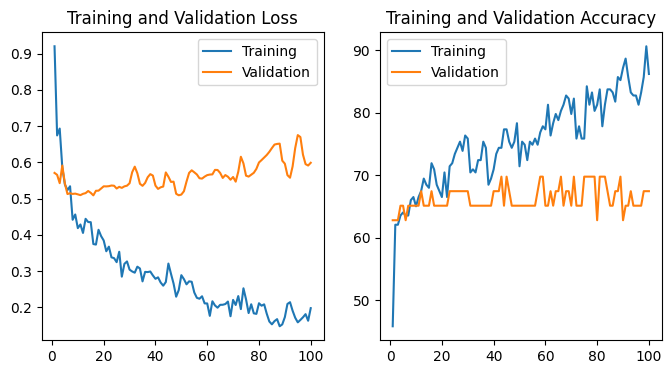

In [70]:
fig, ax = plt.subplots(1,2, figsize=(8,4))
x = range(1,len(train_losses)+1)
ax[0].set_title('Training and Validation Loss')
ax[0].plot(x, train_losses, label='Training')
ax[0].plot(x, val_losses, label='Validation')
ax[0].legend()
ax[1].set_title('Training and Validation Accuracy')
ax[1].plot(x, train_accs, label='Training')
ax[1].plot(x, val_accs, label='Validation')
ax[1].legend()

In [71]:
def Test_PASCAL_model(model, test_dataloader):
  """Test model on test dataset and returns predictions and targets"""
  model.eval()
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)
  test_loss = 0.0
  test_correct = 0
  target = []
  prediction = []
  with torch.no_grad():
    for data, labels in test_dataloader:
      labels = labels.type(torch.LongTensor)
      data, labels = data.to(device), labels.to(device)
      output_logits = model(data)
      pred = torch.softmax(output_logits, dim=1)
      pred = pred.argmax(dim=1)
      prediction.append(pred.cpu().tolist())
      target.append(labels.cpu().tolist())
  target = np.hstack(target)
  prediction = np.hstack(prediction)

  return target, prediction

In [72]:
# Load pretrained model
pretrained_model = HeartSoundClassifier2()
pretrained_model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/ML for Medication Apps/Project/physionet_model.pt'))
cnn = pretrained_model.cnn_layers

PASCAL_model = PASCALClassifier(cnn)
PASCAL_model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/ML for Medication Apps/Project/pascal_model.pt'))
y_true, y_pred = Test_PASCAL_model(PASCAL_model, test_loader)


Classification Report:
              precision    recall  f1-score   support

  extrastole       0.00      0.00      0.00         8
      murmur       0.83      0.56      0.67         9
      normal       0.68      0.96      0.80        27

    accuracy                           0.70        44
   macro avg       0.51      0.51      0.49        44
weighted avg       0.59      0.70      0.63        44



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


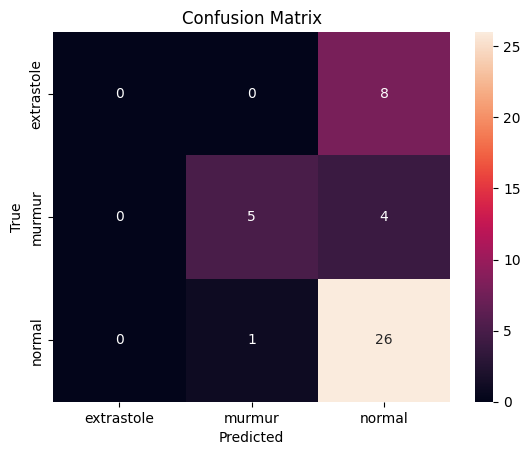

In [73]:
print('\nClassification Report:')
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

confusion_mtx = confusion_matrix(y_true, y_pred)
sns.heatmap(confusion_mtx, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [75]:
recall = metrics.recall_score(y_true,y_pred, average=None)
precision = metrics.precision_score(y_true,y_pred, average=None)
accuracy = metrics.accuracy_score(y_true,y_pred)
f1_score = metrics.f1_score(y_true,y_pred, average=None)

for i,class_name in enumerate(label_encoder.classes_):
  print(f"{class_name} Test metrics:\n\tRecall-rate: {recall[i]:.4f}\n\tPrecision: {precision[i]:.4f}"
       +f"\n\tF1-Score: {f1_score[i]:.4f}")
  
print(f"Overall accuracy: {accuracy:.4f}")

extrastole Test metrics:
	Recall-rate: 0.0000
	Precision: 0.0000
	F1-Score: 0.0000
murmur Test metrics:
	Recall-rate: 0.5556
	Precision: 0.8333
	F1-Score: 0.6667
normal Test metrics:
	Recall-rate: 0.9630
	Precision: 0.6842
	F1-Score: 0.8000
Overall accuracy: 0.7045


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
